# CRM客戶分析


 #### 摘要：
 從kaggle下載電商訂單資料利用RFM模型分析客戶購軌跡製作客戶貼標， 並利用模型預測出客戶未來的購買頻率及金額，最後得出客戶價值。

#### 方法：

第一部分RFM分析：利用RFM模型做出客戶的10類貼標，並用treemap視覺化進一步分析各類客戶數據。

第二部分客戶價值分析：利用lifetimes套件做預測將數據分割套入BGF模型預測出下一次的購買金額及頻率。再利用GGF模型預測未來購買金額及客戶價值CLV。

#### 結果：

分析出兩組關鍵分群，需針對族群名單做銷售投放： 

​高度參與群體champions冠軍客戶及loyal customers忠實客戶此群體包括了最頻繁消費的顧客及最高的平均交易額，分別佔總客戶比15%及17%，平均交易金額為6852 及2746美金，需要持續維持客戶的高度參與並促進更多購買。
需要激勵群體 can't loose不容失去客戶及at risk有風險客戶此兩群體客戶分別佔總客戶比1.7%及14%，都是近一段時間無消費但是過去消費軌跡良好交易金額高需要再次將客戶喚醒，制定可激勵購買的廣告策略。  

預測未來交易：

套入模型結果預測未來一個月平均客戶交易次數為0.5次最高為9次，平均交易額為421美金，客戶價值平均為240美金，由此參考值可規劃出下一個月的行銷預算。



## 1)載入套件

數據清理：numpy, pandas, datetime

數據視覺化：seaborn, matplotlib

客戶價值分析：lifetimes, sklearn

In [152]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from lifetimes.utils import *
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
import squarify
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2)載入dataset

下載資源：Kaggle開放數據

讀取dataset基本訊息 共有525461筆資料

In [251]:
df_1 = pd.read_csv('Year 2009-2010.csv',encoding = 'unicode_escape')
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      525461 non-null  object 
 1   StockCode    525461 non-null  object 
 2   Description  522533 non-null  object 
 3   Quantity     525461 non-null  int64  
 4   InvoiceDate  525461 non-null  object 
 5   Price        525461 non-null  float64
 6   Customer ID  417534 non-null  float64
 7   Country      525461 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.1+ MB


In [252]:
df_1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


## 3) 數據清理

1. 篩選資料：篩選出quantity不為負數資料（負數表示退貨）。數量乘單價增加總價欄位。

In [253]:
df_1=df_1[df_1['Quantity']>0]
df_1['TotalPrice']=df_1['Quantity']*df_1['Price']
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 513135 entries, 0 to 525460
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      513135 non-null  object 
 1   StockCode    513135 non-null  object 
 2   Description  512034 non-null  object 
 3   Quantity     513135 non-null  int64  
 4   InvoiceDate  513135 non-null  object 
 5   Price        513135 non-null  float64
 6   Customer ID  407695 non-null  float64
 7   Country      513135 non-null  object 
 8   TotalPrice   513135 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 39.1+ MB


## 3) 數據清理

2. 日期轉換：利用datetime轉換數字為日期格式，提出月份檢視交易量
   


In [255]:
df_1['InvoiceDate']=pd.to_datetime(df_1['InvoiceDate'])

In [256]:
df_1['InvoiceMonth']=df_1['InvoiceDate'].dt.strftime("%Y-%m")
df_1['InvoiceMonth']

0         2009-12
1         2009-12
2         2009-12
3         2009-12
4         2009-12
           ...   
525456    2010-12
525457    2010-12
525458    2010-12
525459    2010-12
525460    2010-12
Name: InvoiceMonth, Length: 513135, dtype: object

In [257]:
df_1.groupby(['InvoiceMonth']).size()

InvoiceMonth
2009-12    44123
2010-01    30741
2010-02    28365
2010-03    40477
2010-04    33356
2010-05    33971
2010-06    39050
2010-07    32561
2010-08    32640
2010-09    41186
2010-10    57939
2010-11    76596
2010-12    22130
dtype: int64

## 第一部分 RFM客戶貼標
## 3) 數據清理

   利用顧客的最近次購買 (R/Receny)、購買頻率 (F/Frequency) 和付費金額 (M/Monetary)，三項重點數據做RFM模型分析

2. RFM資料準備：利用agg重新整理出'CustomerID', 'recency', 'frequency','monetary'需求欄位

   歸納共有4314筆客戶資料

In [258]:
NOW=datetime(2011,1,1)
features=df_1.groupby('Customer ID').agg({'InvoiceDate':lambda x:(NOW-x.max()).days,
                                       'Invoice':pd.Series.nunique,
                                       'TotalPrice':np.sum,
                                       }).reset_index()
features.columns=['CustomerID', 'recency', 'frequency','monetary' ]

In [259]:
features

,CustomerID,recency,frequency,monetary
0,12346.0,186,11,372.86
1,12347.0,24,2,1323.32
2,12348.0,95,1,222.16
3,12349.0,64,3,2671.14
4,12351.0,32,1,300.93
...,...,...,...,...
4309,18283.0,39,6,641.77
4310,18284.0,88,1,461.68
4311,18285.0,317,1,427.00
4312,18286.0,133,2,1296.43


## 4)客戶貼標 

1. 分割RFM數據做客戶貼標：利用qcut分割 'recency', 'frequency','monetary' 欄位將數據分級（最終得出數據須轉換成字串後合併Ｒ及Ｆ為兩位數）

In [260]:
def get_rfm_scores(dataframe):

    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SEGMENT"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(str)

    return df_

rfm = get_rfm_scores(features)

In [261]:
rfm

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SEGMENT
0,12346.0,186,11,372.86,2,5,2,25
1,12347.0,24,2,1323.32,5,2,4,52
2,12348.0,95,1,222.16,2,1,1,21
3,12349.0,64,3,2671.14,3,3,5,33
4,12351.0,32,1,300.93,5,1,2,51
...,...,...,...,...,...,...,...,...
4309,18283.0,39,6,641.77,4,5,3,45
4310,18284.0,88,1,461.68,3,2,2,32
4311,18285.0,317,1,427.00,1,2,2,12
4312,18286.0,133,2,1296.43,2,3,4,23


## 4)客戶貼標 

2. 客戶貼標：利用正則篩選’RFM_SEGMENT‘數字將客戶分10級存入dictionary，帶入replace建立新欄位’segment‘

In [262]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SEGMENT'].replace(seg_map, regex = True)

rfm.head()

,CustomerID,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SEGMENT,segment
0,12346.0,186,11,372.86,2,5,2,25,cant_loose
1,12347.0,24,2,1323.32,5,2,4,52,potential_loyalists
2,12348.0,95,1,222.16,2,1,1,21,hibernating
3,12349.0,64,3,2671.14,3,3,5,33,need_attention
4,12351.0,32,1,300.93,5,1,2,51,new_customers


## 5)客戶貼標視覺化

1. treemap：利用squarify套件將分級以矩形結構圖顯示，右上角Recency及Frequency數值最高則為冠軍客戶，左下角數值相對最低則為流失客戶

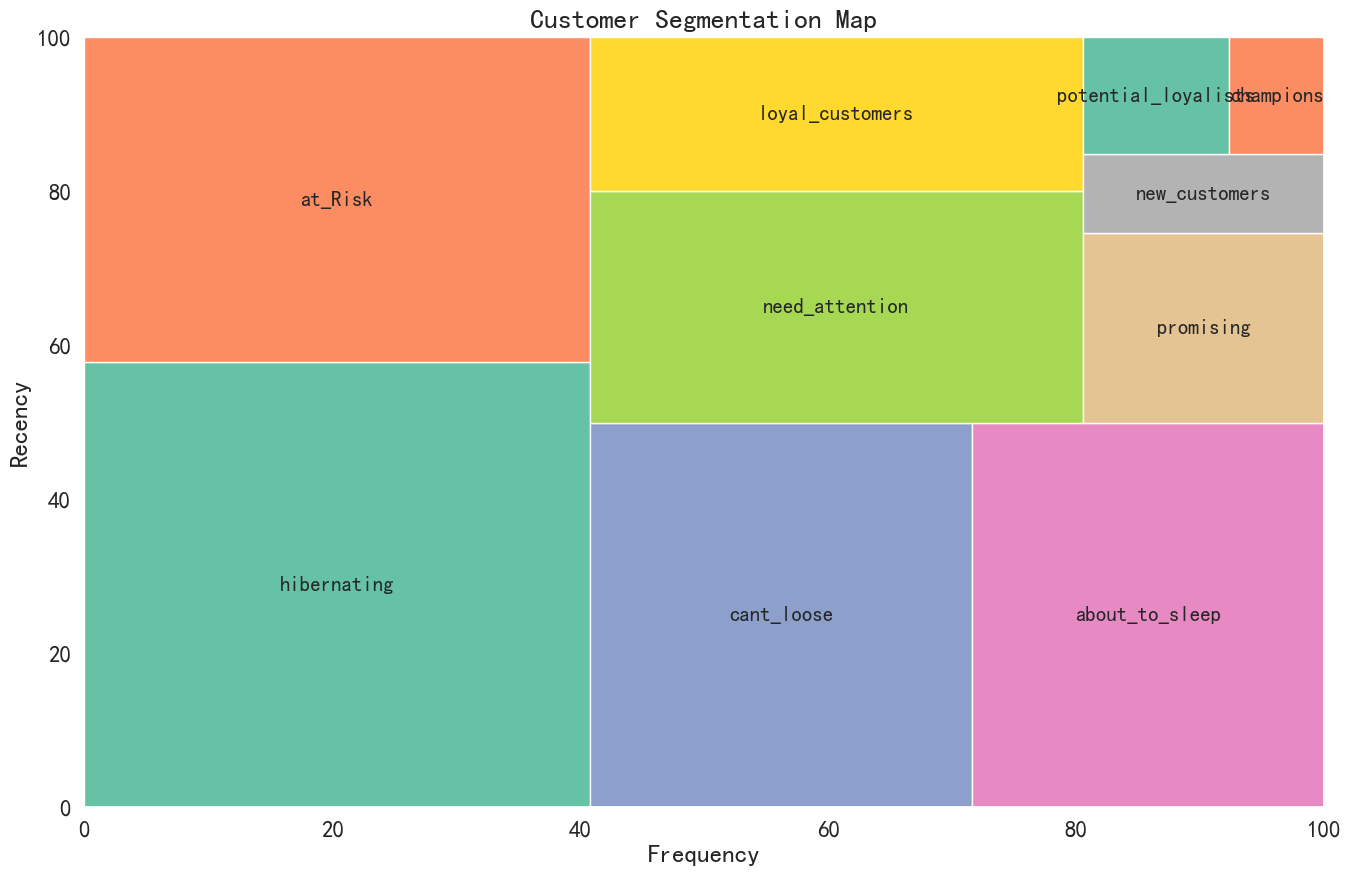

In [263]:
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(
    sizes=segments,
    label=[label for label in seg_map.values()],
    color=sns.color_palette("Set2", len(segments)),
    pad=None,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)
plt.show()

In [264]:
count=rfm.groupby(["segment"]).size().reset_index(name="count").sort_values('count',ascending=False)
count['%']=(100 * count['count'] / count['count'].sum()).round(2)
count

,segment,count,%
4,hibernating,1017,23.57
5,loyal_customers,742,17.20
3,champions,663,15.37
1,at_Risk,611,14.16
8,potential_loyalists,517,11.98
0,about_to_sleep,343,7.95
6,need_attention,207,4.80
9,promising,87,2.02
2,cant_loose,77,1.78
7,new_customers,50,1.16


## 5)客戶貼標視覺化

 2. 長條圖：顯示各分級的詳細數量

Text(0, 0.5, 'Count')

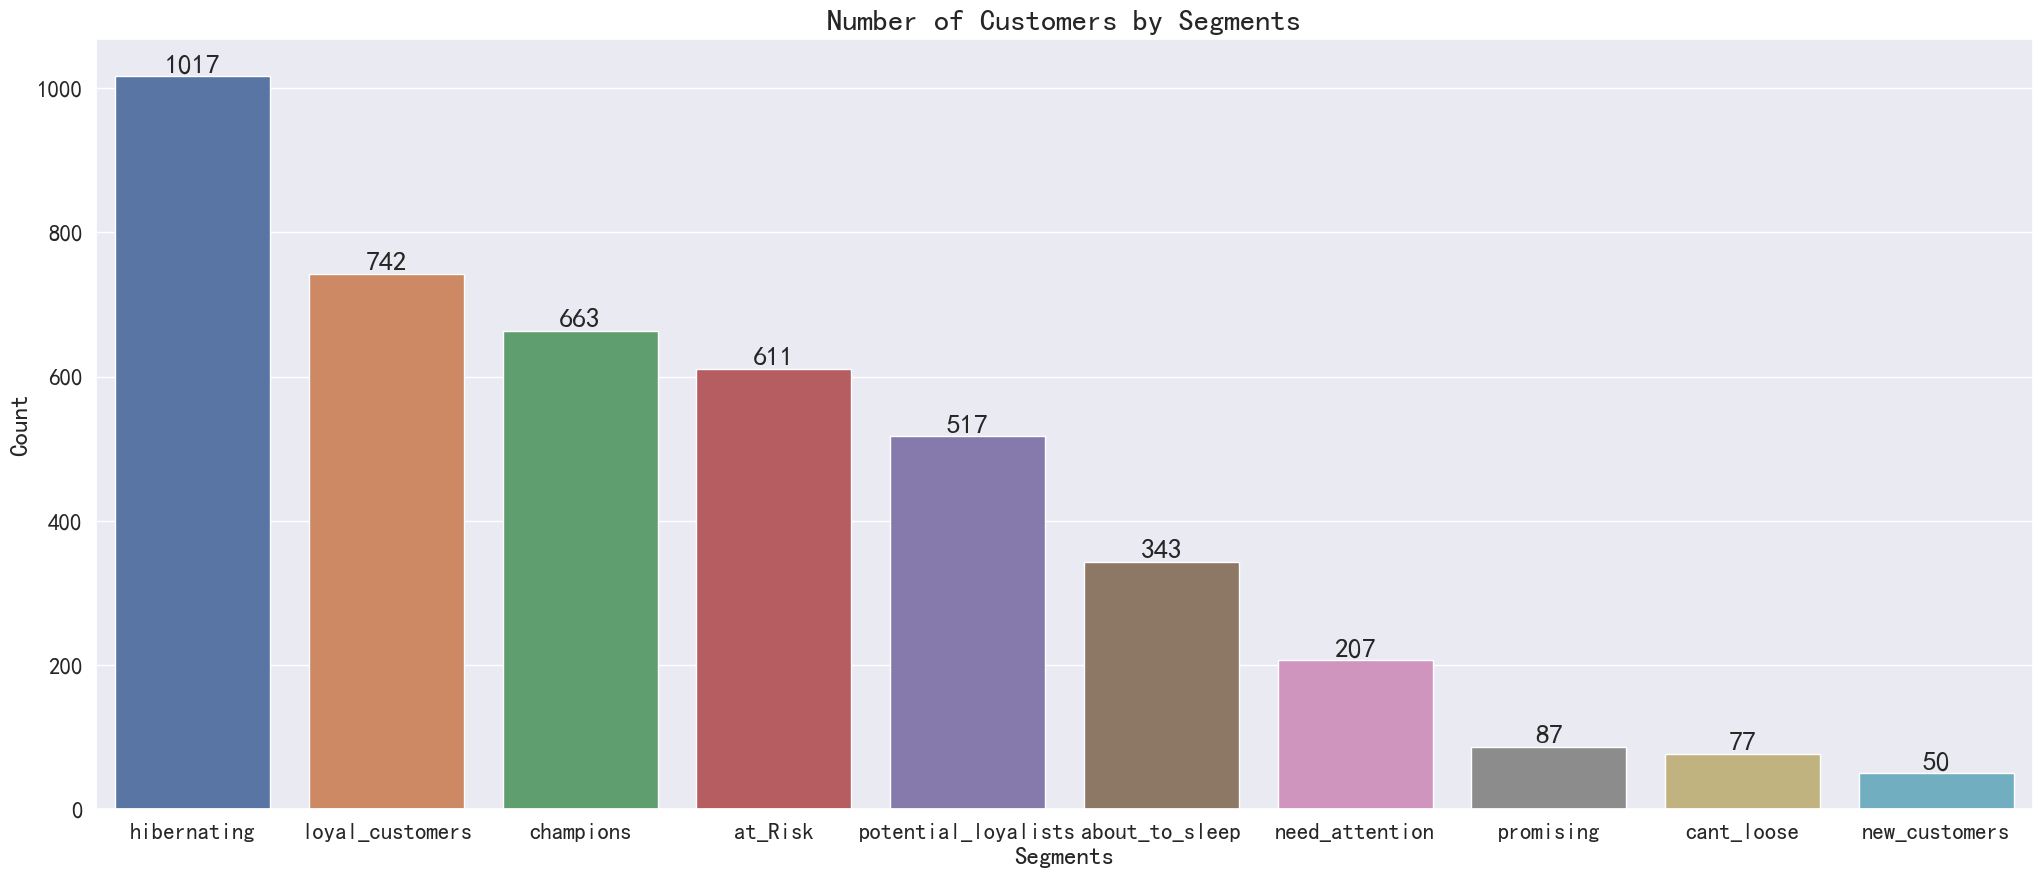

In [265]:
sns.set(rc = {'figure.figsize':(25,10),"font.sans-serif":'simhei'},font_scale=1.5)
ax=sns.barplot(data=count,x='segment',y='count', estimator="sum")
ax.bar_label(ax.containers[0], fontsize=20)
plt.title('Number of Customers by Segments', size = 22)
plt.xlabel("Segments", fontsize=18)
plt.ylabel("Count", fontsize=18)

## 6)客戶貼標數據分析

 1. 重整出RFM數據的平均值、個數及總量，由此可找出幾個關鍵客群

 - champions
 - loyal customers
 - at risk
 - can't loose


In [266]:
rfm[["segment","recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count","sum"])

recency                frequency              \
                           mean count     sum       mean count   sum   
segment                                                                
about_to_sleep        74.819242   343   25663   1.201166   343   412   
at_Risk              173.158756   611  105800   3.073650   611  1878   
cant_loose           145.116883    77   11174   9.116883    77   702   
champions             28.119155   663   18643  12.553544   663  8323   
hibernating          235.057030  1017  239053   1.125860  1017  1145   
loyal_customers       57.287062   742   42507   6.830189   742  5068   
need_attention        74.265700   207   15373   2.449275   207   507   
new_customers         29.580000    50    1479   1.000000    50    50   
potential_loyalists   39.793037   517   20573   2.017408   517  1043   
promising             46.747126    87    4067   1.000000    87    87   

                        monetary                     
                            mean count          sum  
segment                                              
about_to_sleep        441.320000   343   151372.760  
at_Risk              1188.878316   611   726404.651  
cant_loose           4099.450000    77   315657.650  
champions            6852.264167   663  4543051.143  
hibernating           403.183386  1017   410037.504  
loyal_customers      2746.067353   742  2037581.976  
need_attention       1060.357005   207   219493.900  
new_customers         386.199200    50    19309.960  
potential_loyalists   729.510986   517   377157.180  
promising             367.086782    87    31936.550

## 6)客戶貼標數據分析
 2. 分析關鍵分群
 - champions:冠軍客戶這個群體佔了顧客組合的15%，包括663位顧客，他們在過去一個月內購買了商品，平均交易額為6852美金。這個群體包括了最頻繁消費的顧客及最高的平均交易額，需要維持客戶的高度參與促進更多購買。

 - loyal customers:忠實客戶這個群體有742位顧客，在所有顧客組合中，平均購買頻率為6.8次是冠軍客戶外其他分級的2~3倍。平均交易額僅次於冠軍客戶，需要持續維持客戶參與。

 - can't loose:不容失去客戶雖然這個群體已有4個多月未消費，但顧客之前交易頻率高僅次於冠軍客戶，且消費金額接近忠實客戶。因此需要再次將客戶喚醒，制定可激勵購買的廣告策略。
 
 - at risk:有風險客戶這個群體有611位顧客佔總群體的14%，雖購買頻率不高也已經近半年沒有購買，但這些顧客的總交易金額對盈利能夠起到貢獻。需要再次制定可激勵購買的廣告策略。

## 第二部分 客戶價值CLV分析
    利用lifetimes套件將RFM數值套入模型中，預測客戶的再次購買次數及金額，並用套件中的視覺化工具探索數據
## 7)重整數據

重新整理RFM數據:在客戶CLV分析不同於貼標，R的數據為為最後一次購買時間減掉第一次購買時間，如果該名顧客只購買過一次則該欄位值為 0。加入T的數據則是該名顧客的年齡（age），是進行第一次購買成為顧客後，至今經過了多長的時間

In [267]:
clv=df_1.groupby('Customer ID').agg({'InvoiceDate':[lambda x:(NOW-x.min()).days,
                                                    lambda x:(x.max()-x.min()).days,
                                                    ],
                                       'Invoice':pd.Series.nunique,
                                       'TotalPrice':np.sum,
                                       }).reset_index()
clv.columns=['CustomerID','T', 'recency', 'frequency','monetary' ]
clv

,CustomerID,T,recency,frequency,monetary
0,12346.0,382,196,11,372.86
1,12347.0,61,37,2,1323.32
2,12348.0,95,0,1,222.16
3,12349.0,246,181,3,2671.14
4,12351.0,32,0,1,300.93
...,...,...,...,...,...
4309,18283.0,315,275,6,641.77
4310,18284.0,88,0,1,461.68
4311,18285.0,317,0,1,427.00
4312,18286.0,380,247,2,1296.43


也可使用lifetimes的函數直接生成

In [319]:
df_rfmt = summary_data_from_transaction_data(transactions = df_1, 
                                         customer_id_col = 'Customer ID', 
                                         datetime_col = 'InvoiceDate', 
                                         monetary_value_col = 'TotalPrice',
                                         include_first_transaction='False')
df_rfmt

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,7.0,196.0,360.0,53.265714
12347.0,2.0,37.0,39.0,661.660000
12348.0,1.0,0.0,73.0,222.160000
12349.0,3.0,182.0,224.0,890.380000
12351.0,1.0,0.0,10.0,300.930000
...,...,...,...,...
18283.0,5.0,276.0,293.0,128.354000
18284.0,1.0,0.0,66.0,461.680000
18285.0,1.0,0.0,295.0,427.000000


## 8)分割訓練及測試數據

利用lifetimes的函數將數據分割為訓練數據從2009-12到2010-08及驗證數據從2010-09到2010-12

In [268]:
df_rfmt_cal = calibration_and_holdout_data(transactions=df_1, 
                                          customer_id_col="Customer ID",
                                          datetime_col = "InvoiceDate", 
                                          calibration_period_end='2010-08-30',
                                          observation_period_end= '2011-01-01')
df_rfmt_cal

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
Customer ID,,,,,
12346.0,6.0,196.0,259.0,0.0,124.0
12349.0,1.0,19.0,123.0,1.0,124.0
12355.0,0.0,0.0,101.0,0.0,124.0
12358.0,1.0,181.0,265.0,1.0,124.0
12359.0,4.0,199.0,268.0,1.0,124.0
...,...,...,...,...,...
18281.0,0.0,0.0,111.0,0.0,124.0
18283.0,3.0,181.0,192.0,1.0,124.0
18285.0,0.0,0.0,194.0,0.0,124.0


## 9)帶入BG模型

1.  初始化BetaGeoFitter模型利用L2正則找出調整係數

In [269]:
l2_coefs = [0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'], 
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='Customer ID').dropna()

    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

resl = pd.DataFrame(np.array(rmse_list), columns=['rmse_score'])\
             .merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)
resl

,rmse_score,L2 coefs
0,1.590495,0.1
1,1.589659,0.2
2,1.591946,0.3
3,1.594578,0.4
4,1.595945,0.5
5,1.597361,0.6
6,1.599389,0.7
7,1.600167,0.8
8,1.601903,0.9
9,1.602800,1.0


## 9)帶入BG模型

2.  帶入參數：將得出的最佳參數0.2帶入模型

In [ ]:
# Fitting the model using the calibration dataset.
model = BetaGeoFitter(penalizer_coef=0.2)
model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])


## 10)模型數據視覺化

1.  訓練數據與測試數據視覺化：模型表現良好，藍線為實際資料分佈，橘線為模型的預測分佈。其中X軸為 12–8月時的購買次數，Ｙ軸為 9-12月的平均購買次數。舉例來說，在12-8月有進行 2 次購買的顧客，在 9-12月平均會購買 1.3 次左右，而模型則是預測 1.4 次左右。

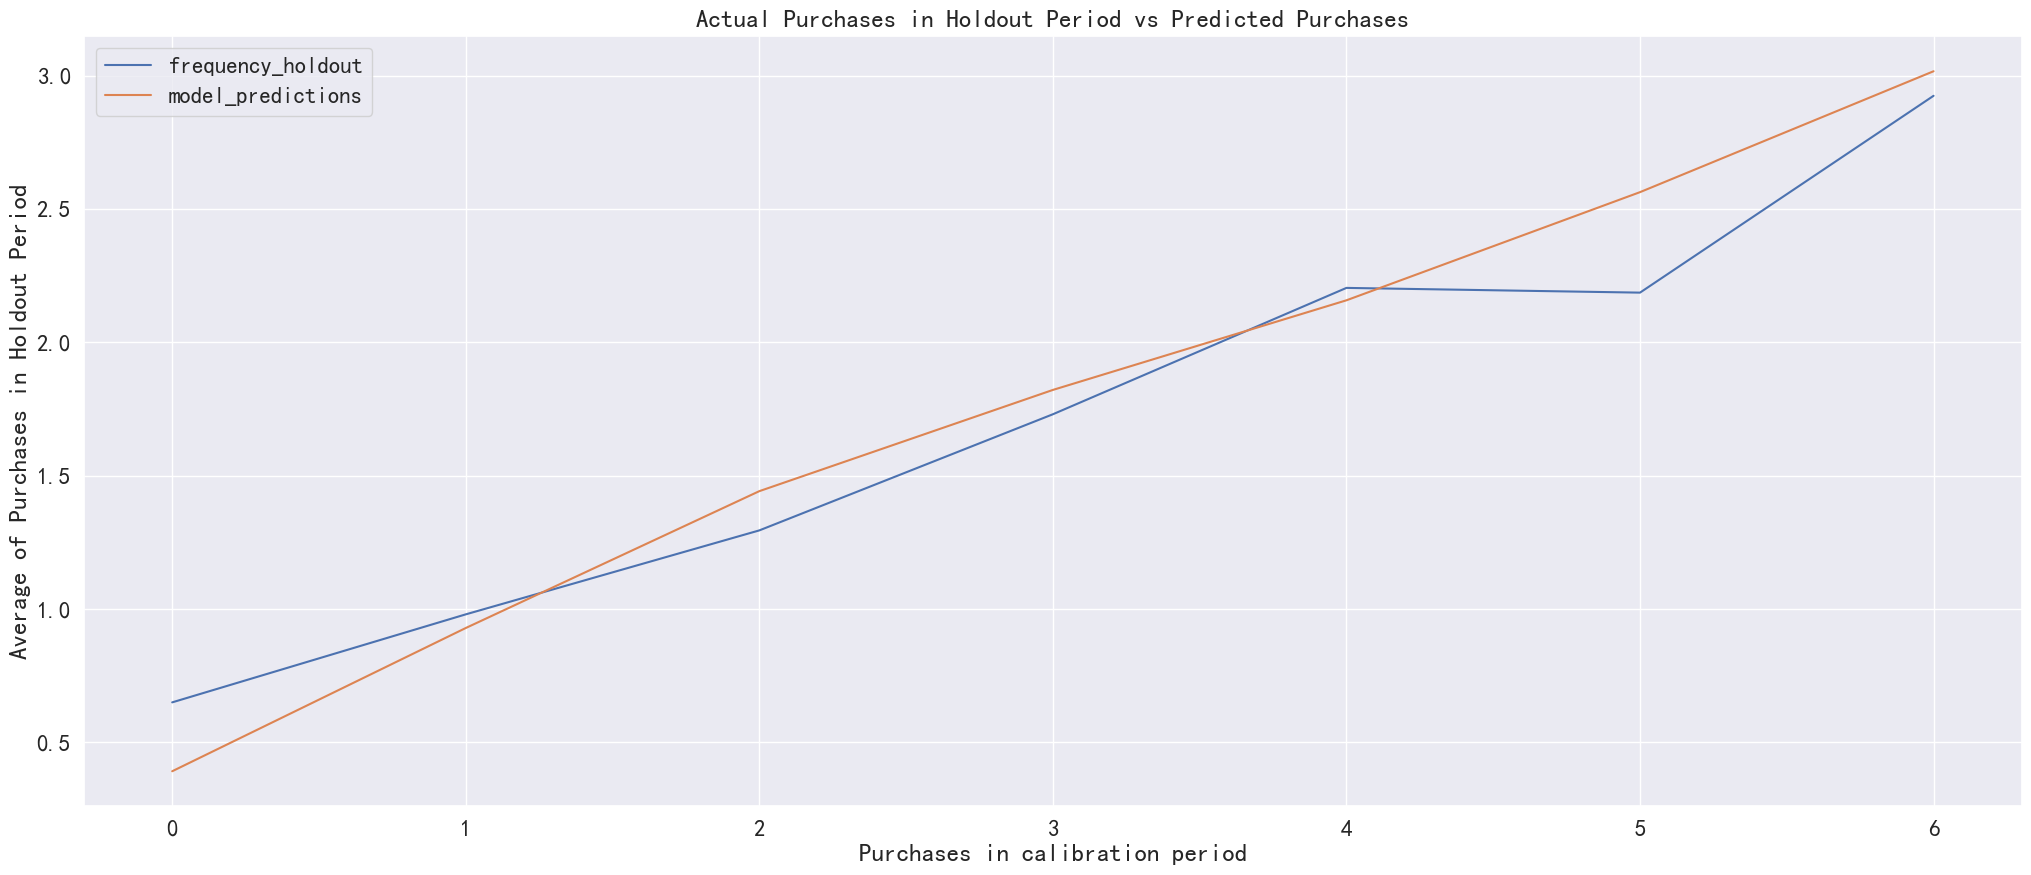

In [271]:
plot_calibration_purchases_vs_holdout_purchases(model,df_rfmt_cal)
plt.show()

## 10)模型數據視覺化

2.  客戶購買熱力圖：利用熱力圖顯示未來顧客在單位時間內進行購買的預期值，其中右下角值最高（偏白色）的那一區，為該店的最佳顧客群；右上角則為曾經頻繁購買，但近期已經不再有購買行為的流失客戶群；至於在 ( 10, 75 ) 處，則為比較模糊的地帶在購買的次數非常低，不確定是否還存活。

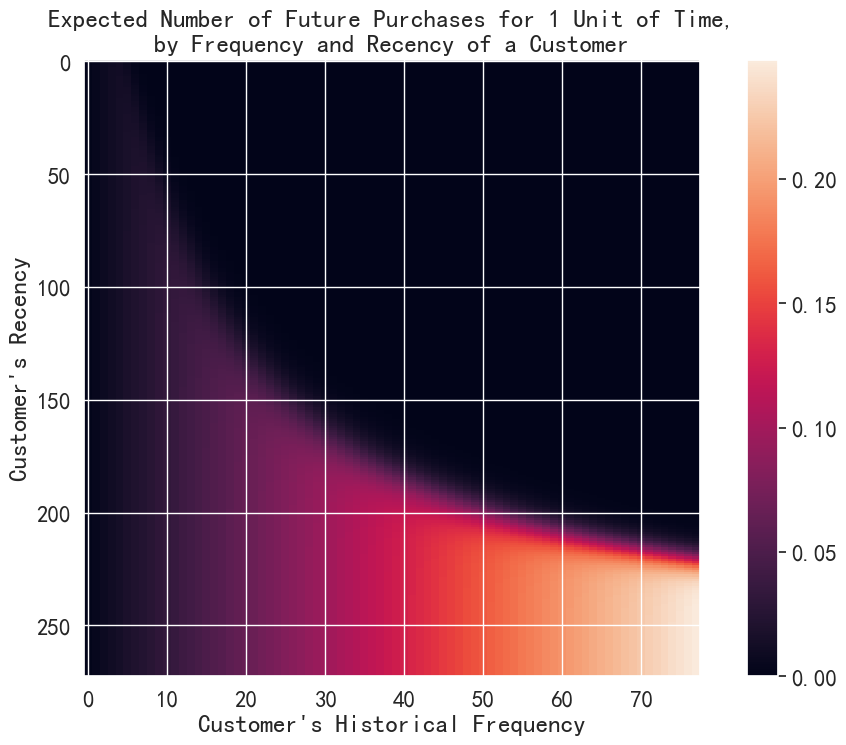

In [ ]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(model)
plt.show()

## 10)模型數據視覺化

 3.  客戶存活熱力圖：利用熱力圖顯示顧客是否還存活，再對照在 ( 10, 75 ) 處，則在此處的客戶大約還有80%的存活率。

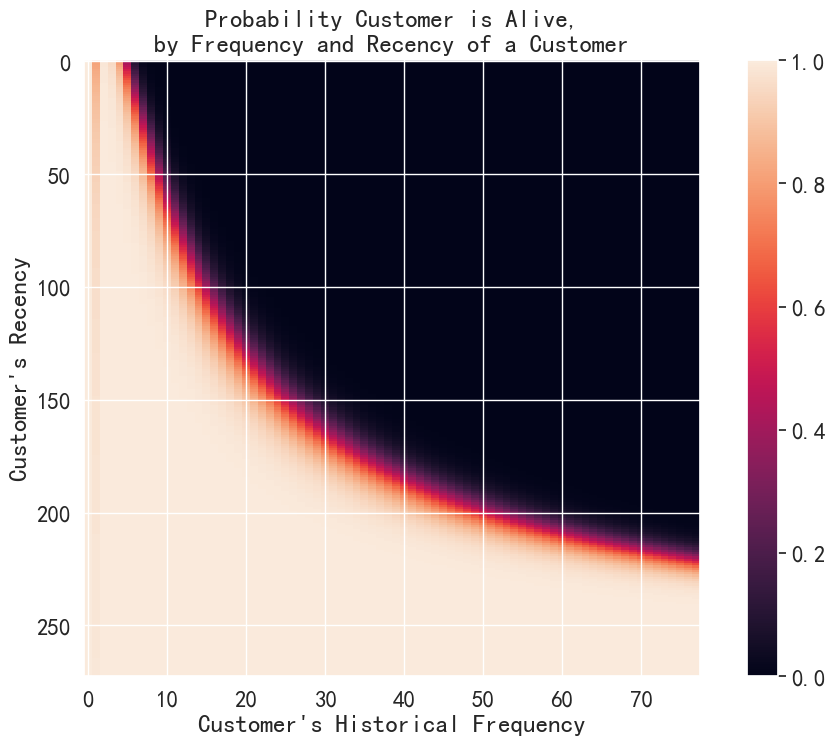

In [297]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(model)
plt.show()

## 11)預測未來購買量

 1. 未來購買次數：將數據帶回模型中預測未來一個月的購買次數，預測結果最高購買次數的客戶約為9次

In [308]:
df_rfmt=df_rfmt[df_rfmt['monetary_value']>0]

In [323]:
df_rfmt['predicted_purchases']=model.conditional_expected_number_of_purchases_up_to_time(
    30, df_rfmt["frequency"], df_rfmt["recency"], df_rfmt["T"]
    )

df_rfmt.sort_values(by='predicted_purchases',ascending=False).head(10)

,frequency,recency,T,monetary_value,CLV,predicted_purchases
Customer ID,,,,,,
14911.0,128.0,373.0,373.0,1188.652891,10912.272010,9.318127
15311.0,110.0,373.0,373.0,509.120545,4032.136262,8.012593
12748.0,96.0,370.0,370.0,238.329792,1675.226620,7.048298
14606.0,95.0,370.0,371.0,196.888526,1371.342892,6.958291
17841.0,85.0,372.0,372.0,351.676471,2167.902165,6.214374
14156.0,79.0,367.0,373.0,2488.186582,14056.234548,5.764157
14527.0,69.0,372.0,372.0,279.470725,1406.754126,5.051086
13089.0,68.0,369.0,372.0,851.647500,4167.212481,4.978377
17377.0,51.0,372.0,372.0,278.793922,1042.148831,3.742387


## 11)預測未來購買量

 2. 關係函數檢驗：需帶入lifetimes裡的gammagamma fitter模型，模型前提是monetary value及frenquency關係係數需為非線性關係，係數不能接近1 或-1，所以帶入corr()函數結果為0.1

In [310]:
df_rfmt[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.106328
frequency,0.106328,1.000000


## 11)預測未來購買量

 3. 帶入GGF模型：初始化模型後將frequency及 monetary value帶入訓練

In [311]:
ggf = GammaGammaFitter()
ggf.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 4312 subjects, p: 2.55, q: 3.48, v: 398.86>

## 11)預測未來購買量

 4. 預測未來購買金額：帶入預測模型函數conditional_expected_average_profit()得到未來平均購買金額為421美金

In [324]:
df_rfmt['pred_monetary'] = ggf.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])
df_rfmt

,frequency,recency,T,monetary_value,CLV,predicted_purchases,pred_monetary
Customer ID,,,,,,,
12346.0,7.0,196.0,360.0,53.265714,53.600585,0.559215,96.808167
12347.0,2.0,37.0,39.0,661.660000,534.668151,0.931794,579.543208
12348.0,1.0,0.0,73.0,222.160000,115.306319,0.369736,314.979483
12349.0,3.0,182.0,224.0,890.380000,301.338533,0.393736,772.985306
12351.0,1.0,0.0,10.0,300.930000,302.038705,0.859487,354.931580
...,...,...,...,...,...,...,...
18283.0,5.0,276.0,293.0,128.354000,84.915335,0.492157,174.262362
18284.0,1.0,0.0,66.0,461.680000,171.025828,0.395763,436.463884
18285.0,1.0,0.0,295.0,427.000000,43.451592,0.104772,418.874209


In [317]:
print(f"預估購買金額:{df_rfmt['pred_monetary'].mean()}")
print(f"實際購買金額:{df_rfmt['monetary_value'].mean()}")

預估購買金額:421.3506763226131
實際購買金額:417.68313637822087


## 12) 客戶價值

 1. CLV：利用模型帶入函數customer_lifetime_value()預測未來1個月的客戶價值，得出平均客戶CLV為240美金可作為後續行銷預算的參考

In [325]:
df_rfmt['CLV']=ggf.customer_lifetime_value(
    model, 
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time=1, 
    freq='D', 
    discount_rate=0.01 
)
df_rfmt

,frequency,recency,T,monetary_value,CLV,predicted_purchases,pred_monetary
Customer ID,,,,,,,
12346.0,7.0,196.0,360.0,53.265714,53.600585,0.559215,96.808167
12347.0,2.0,37.0,39.0,661.660000,534.668151,0.931794,579.543208
12348.0,1.0,0.0,73.0,222.160000,115.306319,0.369736,314.979483
12349.0,3.0,182.0,224.0,890.380000,301.338533,0.393736,772.985306
12351.0,1.0,0.0,10.0,300.930000,302.038705,0.859487,354.931580
...,...,...,...,...,...,...,...
18283.0,5.0,276.0,293.0,128.354000,84.915335,0.492157,174.262362
18284.0,1.0,0.0,66.0,461.680000,171.025828,0.395763,436.463884
18285.0,1.0,0.0,295.0,427.000000,43.451592,0.104772,418.874209


In [330]:
df_rfmt.describe()

,frequency,recency,T,monetary_value,CLV,predicted_purchases,pred_monetary
count,4314.00000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000,4314.000000
mean,3.94089,134.262170,224.531989,417.489496,240.261934,0.514112,421.249123
std,6.01875,132.997752,118.893342,627.532761,676.997239,0.478580,413.454946
min,1.00000,0.000000,0.000000,0.000000,16.838606,0.079178,41.159324
25%,1.00000,0.000000,116.000000,190.187500,75.161147,0.251455,269.211616
50%,2.00000,105.000000,252.500000,303.155000,142.176085,0.402049,335.916675
75%,4.00000,254.000000,328.000000,449.657500,247.250102,0.638130,437.036795
max,128.00000,373.000000,373.000000,13916.340000,24818.181954,9.318127,8845.377852
